<a href="https://colab.research.google.com/github/andres-merino/AprendizajeAutomaticoInicial-05-N0105/blob/main/2-Ejercicios/06-SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="border: none; border-collapse: collapse;">
    <tr>
        <td style="width: 20%; vertical-align: middle; padding-right: 10px;">
            <img src="https://i.imgur.com/nt7hloA.png" width="100">
        </td>
        <td style="width: 2px; text-align: center;">
            <font color="#0030A1" size="7">|</font><br>
            <font color="#0030A1" size="7">|</font>
        </td>
        <td>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="5">
                <b>Escuela de Ciencias Físicas y Matemática</b>
            </font> </p>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="4">
                Aprendizaje Automático Inicial &bull; Máquinas de soporte vectorial
            </font></p>
            <p style="font-style: oblique;"><font color="#0030A1" size="3">
                Andrés Merino &bull; 2024-02
            </font></p>
        </td>  
    </tr>
</table>

---
## <font color='264CC7'> Introducción </font>

A lo largo de este taller, aplicaremos el algoritmo de máquinas de soporte vectorial (SVM) para clasificar un conjunto de datos.

Los paquetes necesarios son:

In [ ]:
# Paquetes necesarios
import pandas as pd  # Manejo de datos
import matplotlib.pyplot as plt  # Visualización

from sklearn.preprocessing import StandardScaler  # Estandarización de datos
from sklearn.datasets import make_blobs, make_circles # Creación de datos
from sklearn.model_selection import train_test_split # División de datos
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  # Métrica de evaluación

# Algoritmo SVC
from sklearn.svm import SVC

import string

---
## <font color='264CC7'> Clasificación </font>


### <font color='264CC7'> Preprocesamiento de datos </font>

Primero necesitas el conjunto de datos. Los datos a utilzar son los seleccionados en la clase anterior.

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Carga el conjunto de datos y procésalos:
<ul>
  <li>Muestra algunos datos.</li>
  <li>Muestra una descripción de los datos.</li>
  <li>Escala los datos si es necesario.</li>
</ul>
</div>

In [ ]:
# Leer los datos
data = pd.read_csv('https://raw.githubusercontent.com/mnloor/Aprendizaje-Automatico/refs/heads/main/Datos/diabetes.csv')

data.rename(columns={
    "Pregnancies": "Embarazos",
    "Glucose": "Glucosa",
    "BloodPressure": "Presión_Arterial",
    "SkinThickness": "Grosor_de_Piel",
    "Insulin": "Insulina",
    "BMI": "IMC",
    "DiabetesPedigreeFunction": "Funcion_Hereditaria_Diabetes",
    "Age": "Edad",
    "Outcome": "Resultado"
}, inplace=True)


# Verificar nombres de columnas
data.columns

# Tomo las columnas de interés
numeric_cols = ['Embarazos', 'Glucosa', 'Presión_Arterial', 'Grosor_de_Piel', 'Insulina','IMC','Funcion_Hereditaria_Diabetes','Edad']
class_col = ['Resultado']


# Generar una lista de etiquetas (A, B, C, ..., AA, AB, ...) dado que no tenemos los nombres de las personas encuestadas
def generate_labels(n):
    labels = []
    while len(labels) < n:
        labels += [f"{a}{b}" for a in string.ascii_uppercase for b in ([""] + list(string.ascii_uppercase))]
    return labels[:n]

# Reemplazar los nombres por las etiquetas
data['Name'] = generate_labels(len(data))


data = data[['Name', *numeric_cols, *class_col]]
# Muestro los primeros registros
display(data.head())

,Name,Embarazos,Glucosa,Presión_Arterial,Grosor_de_Piel,Insulina,IMC,Funcion_Hereditaria_Diabetes,Edad,Resultado
0,A,6,148,72,35,0,33.6,0.627,50,1
1,AA,1,85,66,29,0,26.6,0.351,31,0
2,AB,8,183,64,0,0,23.3,0.672,32,1
3,AC,1,89,66,23,94,28.1,0.167,21,0
4,AD,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
data.describe()

,Embarazos,Glucosa,Presión_Arterial,Grosor_de_Piel,Insulina,IMC,Funcion_Hereditaria_Diabetes,Edad,Resultado
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
# Escalar los datos
scaler = StandardScaler()
X = scaler.fit_transform(data.iloc[:, 1:-1])


### <font color='264CC7'> Determinación del mejor kernel </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Determina el mejor kernel para el modelo SVM.
<ul>
  <li>Genera una gráfica que muestre la precisión de los modelos con diferentes kernels.</li>
  <li>Selecciona el mejor kernel.</li>
</ul>
</div>


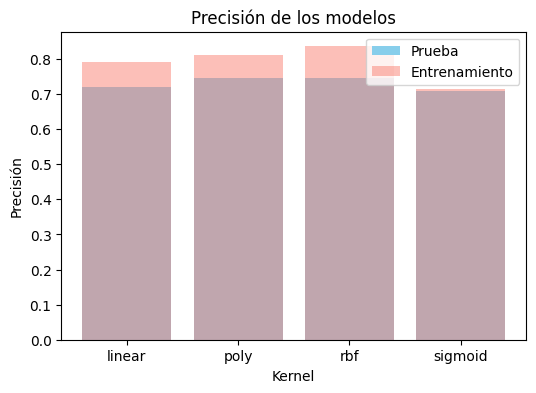

In [ ]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, data['Resultado'], test_size=0.2, random_state=42, stratify=data['Resultado'])

# Determinar el mejor valor de k
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']

# Precisión de los modelos
precisions_test = []
precisions_train = []

for kernel in kernel_values:
    modelo = SVC(kernel=kernel)
    modelo.fit(X_train, y_train)
    y_pred_test = modelo.predict(X_test)
    y_pred_train = modelo.predict(X_train)
    precisions_test.append(accuracy_score(y_test, y_pred_test))
    precisions_train.append(accuracy_score(y_train, y_pred_train))

# Visualizar la precisión en función de k con barras
plt.figure(figsize=(6, 4))
plt.bar(kernel_values, precisions_test, color='skyblue')
plt.bar(kernel_values, precisions_train, color='salmon', alpha=0.5)
plt.title('Precisión de los modelos')
plt.xlabel('Kernel')
plt.ylabel('Precisión')
plt.legend(['Prueba', 'Entrenamiento'])
plt.show()


De acuerdo con la gráfica el rbf sería el mejor


### <font color='264CC7'> Entrenamiento del modelo y evaluación </font>


<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Entrena el modelo y evalúalo:
<ul>
  <li>Entrena el modelo con el kernel seleccionado.</li>
  <li>Evalúa el modelo con el conjunto de datos de prueba.</li>
  <li>Genera una matriz de confusión y muestra las métricas de evaluación.</li>
</ul>
</div>

In [ ]:
# Realizamos el agrupamiento
modelo = SVC(kernel='rbf')
modelo.fit(X_train, y_train)

# Realizar predicciones y evaluar el modelo
y_pred = modelo.predict(X_test)

# Precisión del modelo con dos decimales
accuracy = round(accuracy_score(y_test, y_pred), 2)
print("Precisión del modelo:", accuracy)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(cm)

# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))


Precisión del modelo: 0.75
Matriz de confusión:
[[82 18]
 [21 33]]
Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       100
           1       0.65      0.61      0.63        54

    accuracy                           0.75       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.74      0.75      0.75       154



<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Compara el modelo con otros algoritmos de clasificación vistos en clases anteriores.
</div>

En el contexto de la detección de personas con diabetes, **SVM** ofrece un mejor balance en la detección de casos positivos (personas con diabetes) con un **recall** del 61%, superando al 56% de **KNN**, lo que significa que identifica más personas con diabetes correctamente. Aunque **KNN** tiene una precisión global mayor (77% frente a 75% de SVM) y mejor desempeño en la clase de personas sin diabetes, su bajo **recall** en la clase positiva lo hace menos adecuado en este caso, donde minimizar los falsos negativos es crítico. Por tanto, **SVM** sería preferible, ya que prioriza la detección de personas con diabetes, incluso a costa de un ligero aumento en los falsos positivos.